In [1]:
# First, make sure parent directory is in sys.path
import sys
from pathlib import Path

parent_dir = str(Path.cwd().parent)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Then, reload project modules
import importlib

def reload_project_modules():
    modules_to_reload = [
        "src.face",
        "src.mask",
        "src.utils.project_utils",
        "src.region",
        "src.superpixels",
        "src.feature",
    ]

    for module_name in modules_to_reload:
        if module_name in sys.modules:
            importlib.reload(sys.modules[module_name])
        else:
            __import__(module_name)

In [2]:
import importlib
from pathlib import Path
import cv2
import numpy as np

reload_project_modules()

from src.face import FaceDetector
from src.mask import MaskHandler
from src.utils.project_utils import Utils
from src.region import Region, Phi_N, SuperpixelProbability
from src.superpixels import SuperpixelExtractor
from src.feature import Feature, FeatureExtractor, FeatureDivergence, EFeature

In [3]:
fd = FaceDetector("../assets/lbfmodel.yaml")
mh = MaskHandler()

IMAGE_PATH = Path("test_images/face.jpg")

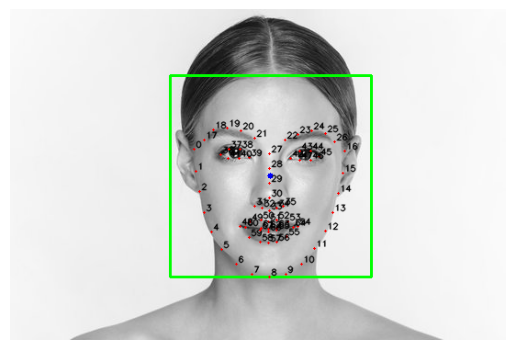

In [4]:
img_rgb, _, _, landmarks_all_faces = fd.detect(IMAGE_PATH, display_indices=True)
Utils.display(img_rgb)

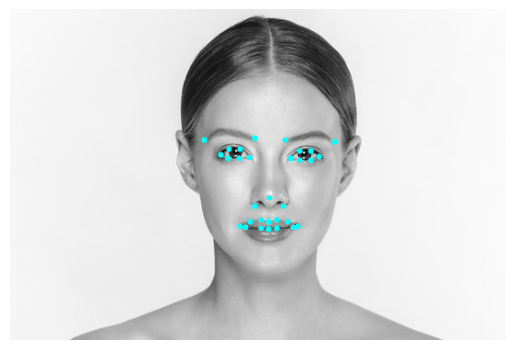

1


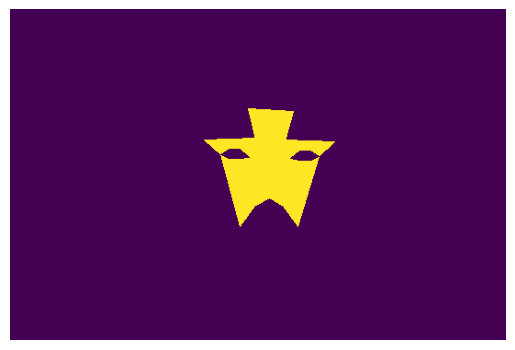

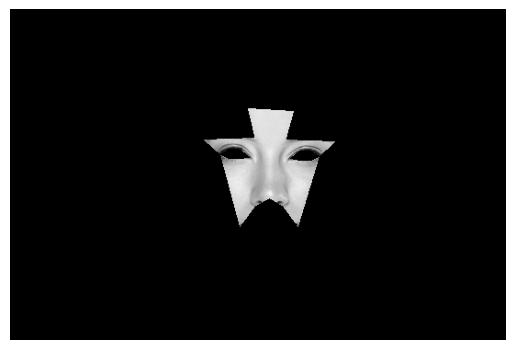

In [5]:
masked_img, selected_pts = mh.get_mask_points(IMAGE_PATH, landmarks_all_faces)
Utils.display(masked_img)

masks, masked_imgs = mh.build_masks(IMAGE_PATH, selected_pts, landmarks_all_faces)
print(len(masks))
Utils.display(masks[0])
Utils.display(masked_imgs[0])

1


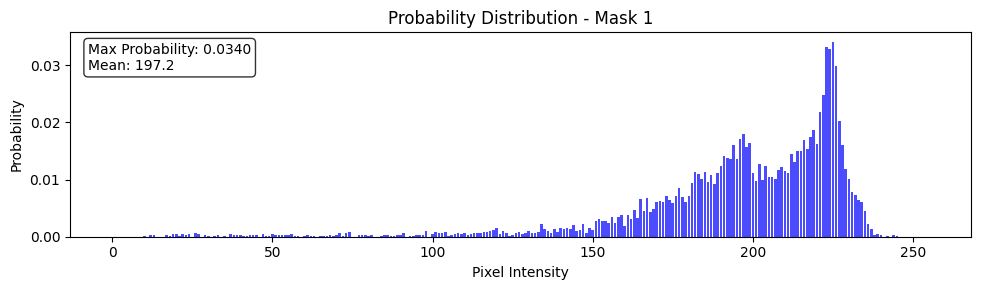

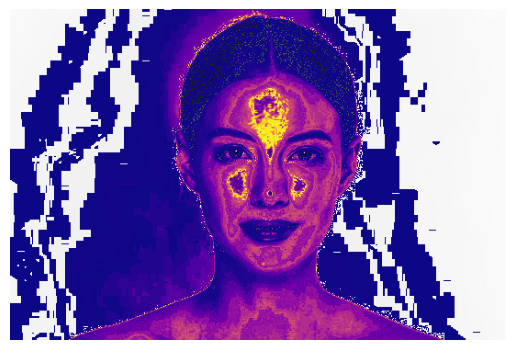

In [6]:
intensity_histograms = mh.get_intensity_histograms(IMAGE_PATH, masks)

print(len(intensity_histograms))
Utils.visualize_histograms(intensity_histograms)
Utils.apply_intensity_probability_map(IMAGE_PATH, intensity_histograms[0])

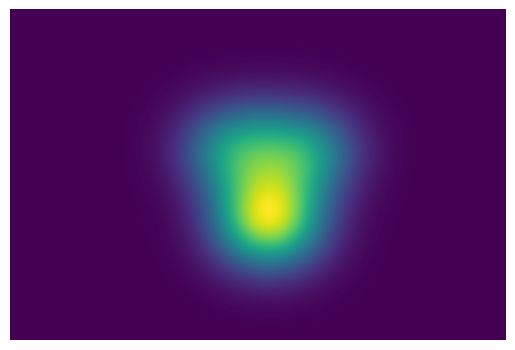

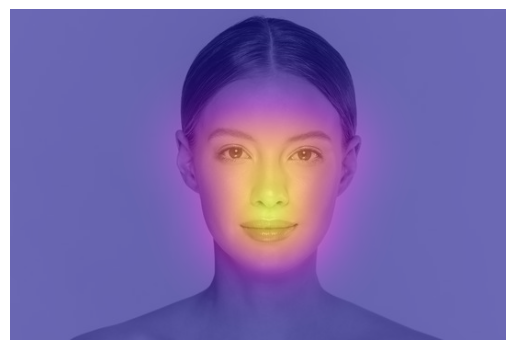

In [7]:
prior_face_masks, heatmaps, heatmaps_blended = mh.get_prior_face_masks(
    IMAGE_PATH, selected_pts
)

idx = 0
Utils.display(prior_face_masks[idx])
Utils.display(heatmaps_blended[idx])

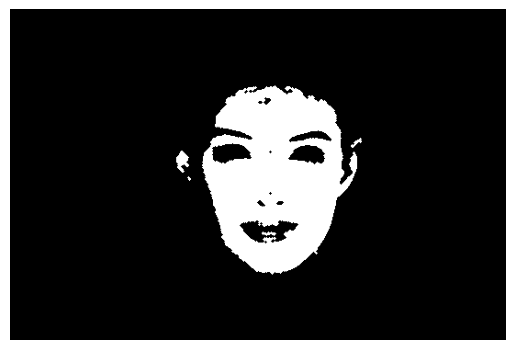

255 0


In [8]:
alpha = 0.9
lambda_ = 0.0018
skin_pixel_maps = mh.get_skin_pixel_maps(
    IMAGE_PATH,
    intensity_histograms,
    prior_face_masks,
    alpha,
    lambda_,
    selected_pts,
    True,
)

skin_pixel_maps = [Utils.morphological_cleanup(s) for s in skin_pixel_maps]

idx = 0
Utils.display(skin_pixel_maps[idx], cmap="gray")
print(skin_pixel_maps[idx].max(), skin_pixel_maps[idx].min())

In [9]:
spe = SuperpixelExtractor(region_size=20)
slic, contoured_img, labels, num_superpixels = spe.get_slic_superpixels(IMAGE_PATH)
num_superpixels

486

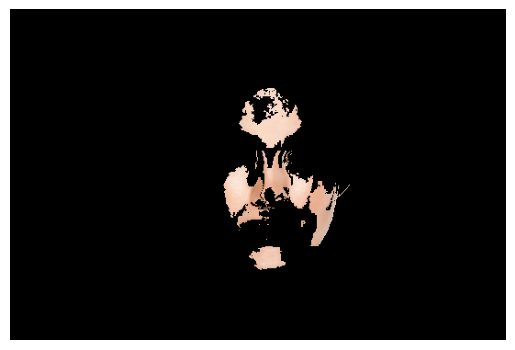

In [10]:
mask_labels = spe.get_mask_labels(slic, skin_pixel_maps[0], 1)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), mask_labels)

In [11]:
fe = FeatureExtractor()
feature_vectors = fe.extract_all_features_superpixels(IMAGE_PATH, slic)

In [12]:
r = Region(
    [
        EFeature.MEAN_INTENSITY,
        EFeature.STD_INTENSITY,
        EFeature.ENTROPY,
        EFeature.LACUNARITY_VECTOR,
    ]
)

mask_fv, non_mask_fv = r.separate_feature_vectors(feature_vectors, mask_labels)

In [13]:
most_favorable_divergences = [r.get_most_favorable_divergence(mask_fv, fv) for fv in non_mask_fv]

d:\devEnv\projects\skin_detection\src\region.py:329: RuntimeWarning: divide by zero encountered in scalar divide
  phi = 1 / (1 + np.exp(-1 / feature))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,

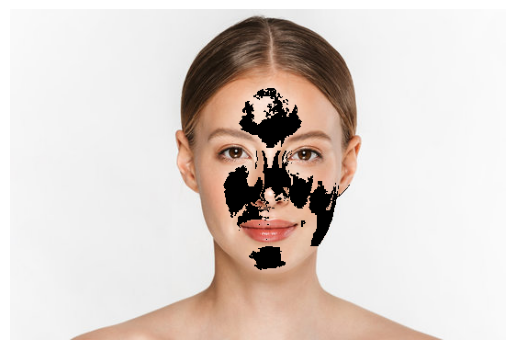

In [14]:
seeds = r.select_seed_superpixel_labels(most_favorable_divergences, 0.99)
print(seeds)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), seeds)

In [ ]:
rg_skin_superpixel_labels, rg_non_skin_superpixel_labels = r.grow(
    slic,
    seeds,
    feature_vectors,
    most_favorable_divergences,
    num_iterations=1,
    kappa=0
)

hello


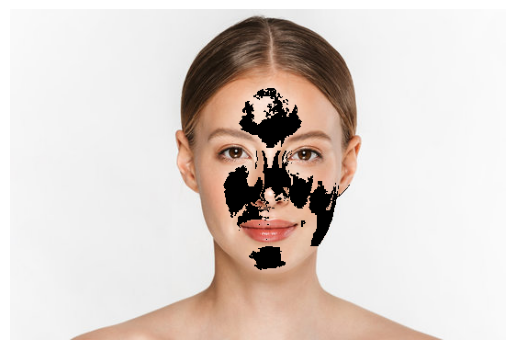

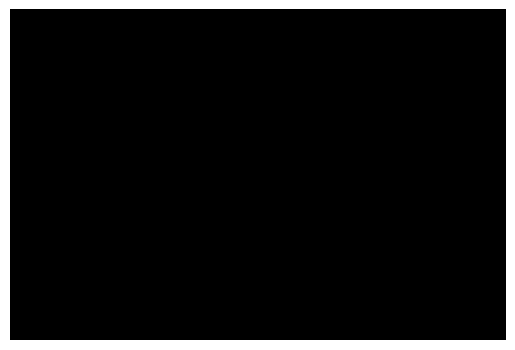

In [16]:

Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), rg_skin_superpixel_labels)
Utils.display_selected_superpixels(IMAGE_PATH, slic.getLabels(), rg_non_skin_superpixel_labels)